# Data Gen

The goal of this project is generate a synthetic dataset that mimics a real dataset.

Synthetic data is annotated information that computer simulations or algorithms generate as an alternative to real-world data. It may be artificial, but synthetic data reflects real-world data, mathematically or statistically. Research demonstrates it can be as good or even better for training an AI model than data based on actual objects, events or people.

Why is it so important? Developers need large, carefully labeled datasets to train neural networks. More diverse training data generally makes for more accurate AI models. The problem is gathering and labeling datasets that may contain a few thousand to tens of millions of elements is time consuming and often prohibitively expensive. Enter synthetic data. A single image that could cost $6 from a labeling service can be artificially generated for six cents, estimates Paul Walborsky, who co-founded one of the first dedicated synthetic data services, AI.Reverie.

In [1]:
import dataprofiler as dp
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [2]:
iris = datasets.load_iris()
data = pd.DataFrame(data=np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"])
data.target = data.target.astype(int) # 'rounding' it off to get rid of the decimal
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
profile_options = dp.ProfilerOptions()
profile_options.set({"correlation.is_enabled": True})

profile = dp.Profiler(data, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns... 


100%|██████████| 5/5 [00:00<00:00, 255.07it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


In [4]:
report = profile.report()

In [5]:
n_samples = report["global_stats"]["samples_used"]
n_variables = len(report["data_stats"])
seed = 123

In [6]:
# build cov matrix
R = report["global_stats"]["correlation_matrix"]

stddevs = [stat["statistics"]["stddev"] for stat in report["data_stats"]]
D = np.diag(stddevs)

cov = D @ R @ D
cov = cov.round(decimals=8)

In [7]:
# initialize X array

means = np.zeros(n_variables)
mvnorm = stats.multivariate_normal(mean=means, cov=cov)
x = mvnorm.rvs(n_samples, random_state=seed)

In [8]:
# now tranform marginals back to uniform distribution

norm = stats.norm()
x = norm.cdf(x)

In [9]:
# generate scalers by range of values in original data

scalers = {}
for col, stat in enumerate(report["data_stats"]):
    _min = stat["statistics"]["min"]
    _max = stat["statistics"]["max"]
    scalers[col] = MinMaxScaler(feature_range=(_min, _max))

In [10]:
# rescale to feature range

for col in scalers:
    x[:, col] = (
        scalers[col]
        .fit_transform(x[:, col].reshape(-1, 1))
        .flatten()
    )

In [11]:
# find number of decimals for each column and round the data to match
precisions = [stat["samples"][0][::-1].find(".") for stat in report["data_stats"]]

for i, precision in enumerate(precisions):
    x[:, i] = np.around(x[:, i], precision if precision > 0 else 0)

In [12]:
new_data = pd.DataFrame(x, columns=[stat["column_name"] for stat in report["data_stats"]])

In [13]:
new_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.9,2.4,6.7,2.0,2.0
1,5.3,4.3,1.0,0.4,0.0
2,7.1,2.7,6.2,1.6,1.0
3,5.7,2.1,6.1,1.4,1.0
4,4.6,2.9,1.7,1.1,1.0
...,...,...,...,...,...
145,4.5,3.2,1.0,0.2,0.0
146,4.8,2.0,5.0,1.9,1.0
147,5.3,3.5,1.1,0.5,0.0
148,6.4,3.1,5.0,1.5,1.0


<AxesSubplot:>

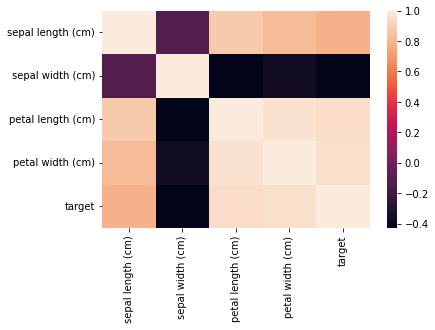

In [14]:
sns.heatmap(data.corr())

<AxesSubplot:>

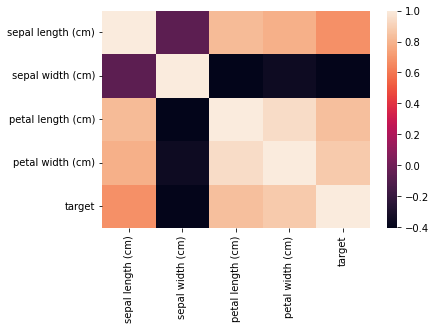

In [15]:
sns.heatmap(new_data.corr())

In [16]:
iris = datasets.load_iris()

training_data, test_data = train_test_split(iris.data, test_size=0.2, random_state=seed)
training_target, test_target = train_test_split(iris.target, test_size=0.2, random_state=seed)

clf = SVC()

clf.fit(training_data, training_target)

SVC()

In [17]:
test_results = clf.predict(test_data)
model_accuracy = list(test_results == test_target).count(True) / len(test_target)

print(f"The model was {round(model_accuracy * 100, 2)}% accurate on the authentic data")

The model was 96.67% accurate on the authentic data


In [18]:
synthetic_data = new_data.to_numpy()[:,:-1]
synthetic_target = new_data.to_numpy()[:,-1:].flatten()

synthetic_results = clf.predict(synthetic_data)
synthetic_accuracy = list(synthetic_results == synthetic_target).count(True) / len(synthetic_target)

print(f"The model was {round(synthetic_accuracy * 100, 2)}% accurate on the synthetic data")

The model was 72.67% accurate on the synthetic data
